In [1]:
sys.path.append('../')
import lasio
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
pd.set_option('max_columns', None)
import os

In [2]:
%%capture
from tqdm import tqdm_notebook

In [3]:
df = pd.read_csv('../checkpoints/total_df.csv.gz', compression='gzip')

In [4]:
litho_data = df[pd.notnull(df['LITHOLOGY_GEOLINK'])].drop(columns=['WELL_NAME']) # not null dataframe (model training)

In [5]:
litho_data['LITHOLOGY_GEOLINK'] = litho_data['LITHOLOGY_GEOLINK'].astype(int)

In [6]:

litho_data["Set"] = np.random.choice(["train_red", "rest"], p =[.3, .7], size=(litho_data.shape[0],))

train = litho_data[litho_data.Set == 'train_red']

In [7]:
print(train.shape, litho_data.shape)

(388881, 9) (1294715, 9)


In [8]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['LITHOLOGY_GEOLINK', 'Set'])

Y = train['LITHOLOGY_GEOLINK']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [9]:
print('### Training Dataset: ### ', x_train.shape, y_train.shape)
print('### Validation Dataset: ### ', x_val.shape, y_val.shape)
print('### Test Dataset: ### ', x_test.shape, y_test.shape)

### Training Dataset: ###  (248883, 7) (248883,)
### Validation Dataset: ###  (62221, 7) (62221,)
### Test Dataset: ###  (77777, 7) (77777,)


In [10]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [11]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = str(1)

In [12]:
clf = TabNetClassifier(               optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cuda


In [13]:
max_epochs = 1000

clf.fit(
    X_train=x_train.values, y_train=y_train,
    eval_set=[(x_train.values, y_train), (x_val.values, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=max_epochs , patience=50,
    batch_size=1024,
    num_workers=0,
    weights=1,
    drop_last=False
)

91 | valid_balanced_accuracy: 0.65634 |  1:06:09s
epoch 167| loss: 0.87022 | train_balanced_accuracy: 0.72173 | valid_balanced_accuracy: 0.65334 |  1:06:33s
epoch 168| loss: 0.86846 | train_balanced_accuracy: 0.72346 | valid_balanced_accuracy: 0.65481 |  1:06:57s
epoch 169| loss: 0.86834 | train_balanced_accuracy: 0.72363 | valid_balanced_accuracy: 0.65222 |  1:07:20s
epoch 170| loss: 0.86644 | train_balanced_accuracy: 0.72884 | valid_balanced_accuracy: 0.66207 |  1:07:44s
epoch 171| loss: 0.87282 | train_balanced_accuracy: 0.72253 | valid_balanced_accuracy: 0.65133 |  1:08:08s
epoch 172| loss: 0.86836 | train_balanced_accuracy: 0.72564 | valid_balanced_accuracy: 0.65875 |  1:08:31s
epoch 173| loss: 0.865   | train_balanced_accuracy: 0.72528 | valid_balanced_accuracy: 0.65725 |  1:08:55s
epoch 174| loss: 0.86427 | train_balanced_accuracy: 0.72581 | valid_balanced_accuracy: 0.65898 |  1:09:19s
epoch 175| loss: 0.8647  | train_balanced_accuracy: 0.72883 | valid_balanced_accuracy: 0.65834

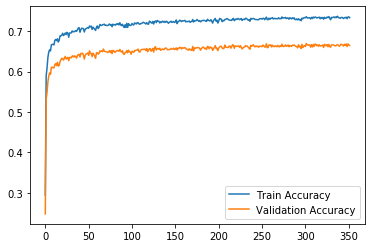

In [24]:
plt.plot(clf.history['train_balanced_accuracy'], label='Train Accuracy')
plt.plot(clf.history['valid_balanced_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

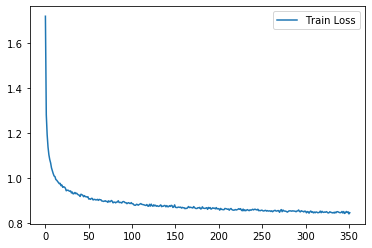

In [26]:
plt.plot(clf.history['loss'], label='Train Loss')
plt.legend()
plt.show()


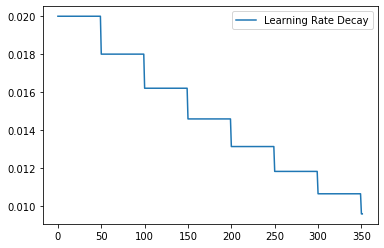

In [27]:
plt.plot(clf.history['lr'], label='Learning Rate Decay')
plt.legend()
plt.show()
